We will compare the sequential and vectorized implementations of the TMM in WPTherml for a fixed number of wavelengths with varying numbers of layers.  We will also compare this to the vectorized TMM implementation in the vtmm package.  

Note you will need to ensure vtmm and tensorflow are installed for this comparison.  

`pip install tensorflow vtmm` 

should install them both!

In [4]:
import wptherml
from matplotlib import pyplot as plt
import numpy as np
import time
import tensorflow as tf
from vtmm import tmm_rt


The next block will run the comparisons!

In [5]:
# Example input dictionary
test_args = {
    "wavelength_list": [400e-9, 800e-9, 3000],  # 100 wavelengths from 400 to 800 nm
    "material_list": ["Air", "SiO2", "TiO2", "Air"],
    "thickness_list": [0, 200e-9, 10e-9, 0],
}

sf = wptherml.SpectrumFactory()


def build_stack(n_layers, mat_a="SiO2", mat_b="TiO2", ri_a = 1.5, ri_b = 2.4, t_a=200e-9, t_b=10e-9):
    """
    Build material_list and thickness_list for n_layers finite layers.
    Alternates mat_a and mat_b, with Air on both sides.
    """
    material_list = ["Air"]
    thickness_list = [0.0]
    ri_list = [1.0]
    vtmm_d = []

    for i in range(n_layers):
        if i % 2 == 0:
            material_list.append(mat_a)
            thickness_list.append(t_a)
            vtmm_d.append(t_a)
            ri_list.append(ri_a)
        else:
            material_list.append(mat_b)
            thickness_list.append(t_b)
            vtmm_d.append(t_b)
            ri_list.append(ri_b)

    material_list.append("Air")
    thickness_list.append(0.0)
    ri_list.append(1.0)

    return material_list, thickness_list, ri_list, vtmm_d



# Example: loop over a range of layer counts
n_lay = []
ser_time = []
vec_time = []
vtmm_time = []

for n_layers in [4, 10, 12, 16, 18, 20, 22, 24, 26, 28, 30, 35, 40]:
    mats, thks, ris, vtmm_d = build_stack(n_layers)
    test_args = {
        "wavelength_list": [400e-9, 800e-9, 3000],
        "material_list": mats,
        "thickness_list": thks
    }
    
    n = tf.constant(ris) # Layer refractive indices 
    d = tf.constant(vtmm_d) # Layer thicknesses 
    kx = tf.linspace(0.0, 2*np.pi*220e12/299792458, 3000) # Parallel wavevectors
    omega = tf.linspace(150e12, 220e12, 3000) * 2 * np.pi # Angular frequencies
    
    # t and r will be 2D tensors of shape [ num kx, num omega ]
    start = time.time()
    t, r = tmm_rt('s', omega, kx, n, d)
    end = time.time()
    vtmm_init = end-start
    
    start = time.time()
    test_serial = sf.spectrum_factory('Tmm', test_args)
    end = time.time()

    serial_init = end-start

    start = time.time()
    test_vec = sf.spectrum_factory('VecTmm', test_args)
    end = time.time()
    
    vec_init = end-start
    if n_layers > 4:
        n_lay.append(n_layers)
        ser_time.append(serial_init)
        vec_time.append(vec_init)
        vtmm_time.append(vtmm_init)
    
    

TEW is 0.3333333333333333
REW is 0.3333333333333333
RSW is 0.3333333333333333
1.0
 Your spectra have been computed! 😎 
TEW is 0.3333333333333333
REW is 0.3333333333333333
RSW is 0.3333333333333333
1.0
 Your spectra have been computed! 😎 
TEW is 0.3333333333333333
REW is 0.3333333333333333
RSW is 0.3333333333333333
1.0
 Your spectra have been computed! 😎 
TEW is 0.3333333333333333
REW is 0.3333333333333333
RSW is 0.3333333333333333
1.0
 Your spectra have been computed! 😎 
TEW is 0.3333333333333333
REW is 0.3333333333333333
RSW is 0.3333333333333333
1.0
 Your spectra have been computed! 😎 
TEW is 0.3333333333333333
REW is 0.3333333333333333
RSW is 0.3333333333333333
1.0
 Your spectra have been computed! 😎 
TEW is 0.3333333333333333
REW is 0.3333333333333333
RSW is 0.3333333333333333
1.0
 Your spectra have been computed! 😎 
TEW is 0.3333333333333333
REW is 0.3333333333333333
RSW is 0.3333333333333333
1.0
 Your spectra have been computed! 😎 
TEW is 0.3333333333333333
REW is 0.3333333333333

The next block will plot the comparisons and report the average speedup!

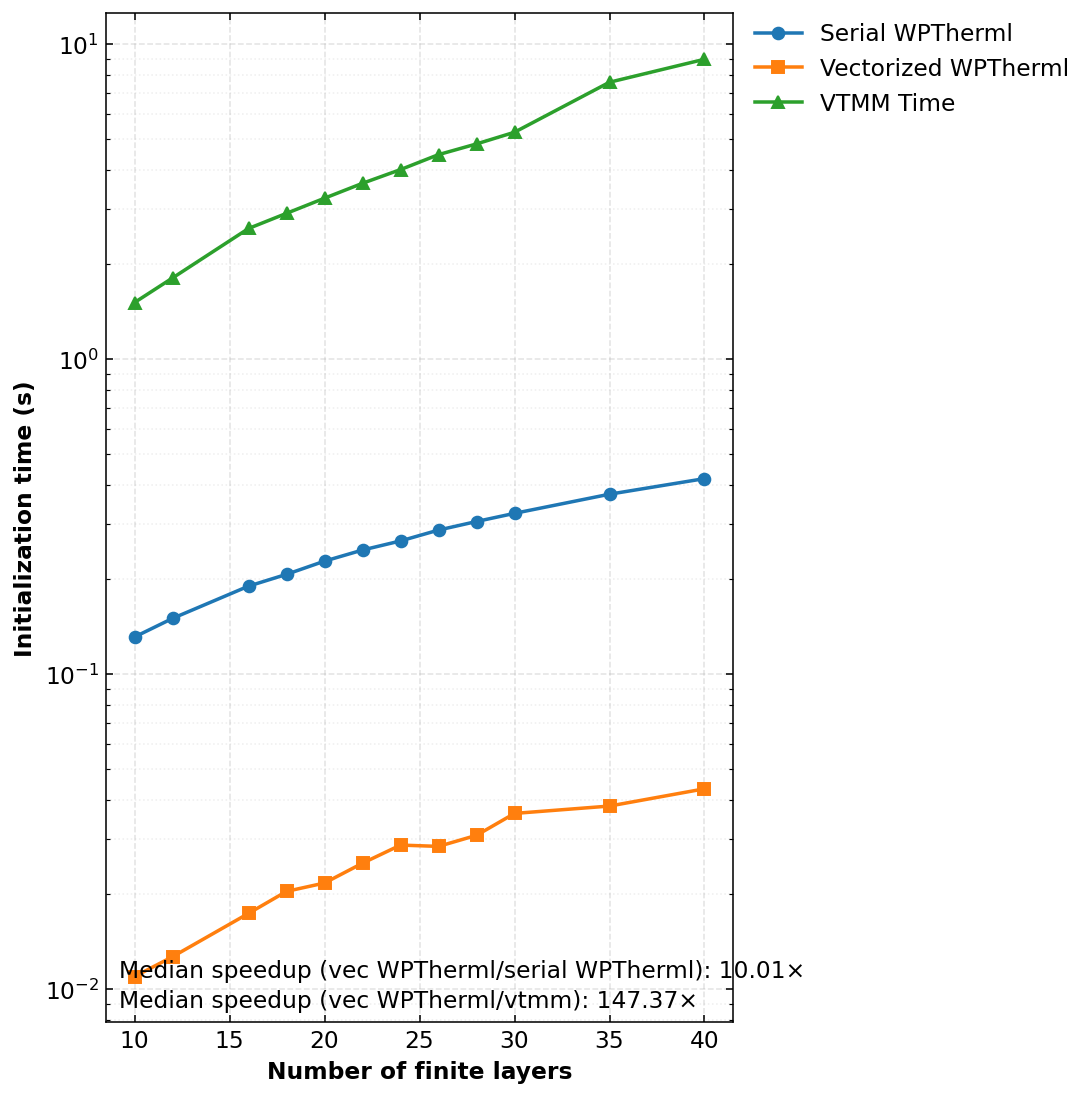

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, LogLocator

def plot_tmm_timings(n_lay, ser_time, vec_time, vtmm_time,
                     title="Initialization time vs. number of layers",
                     x_label="Number of finite layers",
                     y_label="Initialization time (s)",
                     save_prefix=None):
    # --- sensible defaults for papers ---
    plt.rcParams.update({
        "figure.dpi": 140,
        "savefig.dpi": 300,
        "font.size": 12,
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "legend.frameon": False,
        "lines.linewidth": 1.8,
        "lines.markersize": 6,
    })

    fig = plt.figure(figsize=(8.0, 8.0))  # single-panel, journal-friendly
    ax = plt.gca()

    # main series (no explicit colors)
    ax.plot(n_lay, ser_time, marker="o", label="Serial WPTherml")
    ax.plot(n_lay, vec_time, marker="s", label="Vectorized WPTherml")
    ax.plot(n_lay, vtmm_time, marker="^", label="VTMM Time")

    # axes / scales
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_yscale("log")
    

    # ticks & grid tuned for log y
    ax.yaxis.set_minor_locator(LogLocator(subs=np.arange(2, 10) * 0.1))
    ax.grid(True, which="major", linestyle="--", alpha=0.35)
    ax.grid(True, which="minor", linestyle=":", alpha=0.20)

    # nicer integer-ish x ticks if x is linear
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.tick_params(which="both", direction="in", top=True, right=True)

    # legend outside when space is tight
    leg = ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0.0)
    # If you prefer inside the axes, comment the above and use: ax.legend(loc="best")

    # optional: annotate median speedup of vectorized vs serial
    try:
        speedup = np.median(np.asarray(ser_time) / np.asarray(vec_time))
        vtmm_speedup = np.median(np.asarray(vtmm_time) / np.asarray(vec_time))
        ax.text(0.02, 0.04, f"Median speedup (vec WPTherml/serial WPTherml): {speedup:.2f}×",
                transform=ax.transAxes, ha="left", va="bottom")
        ax.text(0.02, 0.01, f"Median speedup (vec WPTherml/vtmm): {vtmm_speedup:.2f}×",
                transform=ax.transAxes, ha="left", va="bottom")
    except Exception:
        pass

    plt.tight_layout()

    if save_prefix:
        fig.savefig(f"{save_prefix}.png")
        fig.savefig(f"{save_prefix}.svg")  # vector format for publication

    plt.show()

# --- usage with your arrays ---
plot_tmm_timings(n_lay, ser_time, vec_time, vtmm_time, save_prefix="tmm_timings_3000wl_vs_layers")
